In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import kaggle
import mlflow
import mlflow.sklearn
import joblib
import re
from pathlib import Path

In [5]:
# My preprocess.py
from pipeline.preprocess import InitialCleaner, build_preprocessor, prepare_y

### Load dataset

In [6]:
# --- 1) Ensure data on disk (download only if missing) ---
data_dir = Path("../data")
data_dir.mkdir(parents=True, exist_ok=True)

csv_files = list(data_dir.glob("*.csv"))
if not csv_files:
    kaggle.api.dataset_download_files(
        "uciml/adult-census-income",
        path=str(data_dir),
        unzip=True
    )
    print("Dataset downloaded and unzipped.")
    csv_files = list(data_dir.glob("*.csv"))
    if not csv_files:
        raise FileNotFoundError("No CSV file found after unzipping dataset.")

# Prefer a file named like 'adult.csv', otherwise take the first CSV
preferred = [p for p in csv_files if "adult" in p.name.lower() and "test" not in p.name.lower()]
csv_path = (preferred or csv_files)[0]
print(f"Using dataset: {csv_path}")

# --- 2) Load into DataFrame with header fallback ---
adult_columns = [
    "age","workclass","fnlwgt","education","education_num","marital_status",
    "occupation","relationship","race","sex","capital_gain","capital_loss",
    "hours_per_week","native_country","income"
]

def load_adult_csv(path: Path) -> pd.DataFrame:
    # Try with header inference first
    try:
        df = pd.read_csv(path)
        # If header wasn't present or 'income' missing, reload with explicit names
        normalized_cols = [c.strip().lower().replace("-", "_").replace(".", "_") for c in df.columns]
        if ("income" not in normalized_cols) or (df.shape[1] != len(adult_columns)):
            df = pd.read_csv(path, header=None, names=adult_columns)
    except Exception:
        # Robust fallback: explicit names
        df = pd.read_csv(path, header=None, names=adult_columns)
    return df

df = load_adult_csv(csv_path)
print(df.shape)
df.head()

Using dataset: ..\data\adult.csv
(32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### Clean the data, split, preprocess training

In [7]:
# 1) Apply the stateless cleaner (drops ?, fixes names, adds engineered columns, etc.)
cleaner = InitialCleaner()
df_clean = cleaner.fit_transform(df)

# 2) Create target
y = prepare_y(df_clean)

# 3) Drop income from features AFTER prepare_y
X_df = df_clean.drop(columns=[c for c in df_clean.columns if c.replace(".","_").strip().lower()=="income"])

# 4) Train/test split
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=7, stratify=y
)

# 5) Build & fit the ColumnTransformer on TRAIN ONLY
preprocessor = build_preprocessor(X_train_df)
X_train = preprocessor.fit_transform(X_train_df)
X_test  = preprocessor.transform(X_test_df)

### Train three models

In [8]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, random_state=42, tree_method="hist", n_jobs=-1, eval_metric="logloss"
    ),
}
fitted = {name: mdl.fit(X_train, y_train) for name, mdl in models.items()}

### Evaluate

In [9]:
def evaluate(clf, Xtr, ytr, Xte, yte):
    yhat_tr = clf.predict(Xtr)
    yhat_te = clf.predict(Xte)
    # proba/decision for ROC-AUC
    if hasattr(clf, "predict_proba"):
        p_te = clf.predict_proba(Xte)[:, 1]
        p_tr = clf.predict_proba(Xtr)[:, 1]
    else:
        # fallback to decision_function then normalize via rank (rare here)
        from sklearn.preprocessing import MinMaxScaler
        p_te = MinMaxScaler().fit_transform(clf.decision_function(Xte).reshape(-1,1)).ravel()
        p_tr = MinMaxScaler().fit_transform(clf.decision_function(Xtr).reshape(-1,1)).ravel()

    metrics = {
        "acc_train": accuracy_score(ytr, yhat_tr),
        "acc_test":  accuracy_score(yte, yhat_te),
        "prec_test": precision_score(yte, yhat_te, zero_division=0),
        "rec_test":  recall_score(yte, yhat_te, zero_division=0),
        "f1_test":   f1_score(yte, yhat_te, zero_division=0),
        "roc_auc_test": roc_auc_score(yte, p_te),
    }
    return metrics, p_te

results = {}
probs = {}
for name, clf in fitted.items():
    m, p = evaluate(clf, X_train, y_train, X_test, y_test)
    results[name] = m
    probs[name] = p

pd.DataFrame(results).T.sort_values("f1_test", ascending=False)

,acc_train,acc_test,prec_test,rec_test,f1_test,roc_auc_test
XGBoost,0.890505,0.852147,0.735340,0.634487,0.681201,0.914248
RandomForest,0.970658,0.834742,0.687176,0.617177,0.650298,0.886534
LogReg,0.844544,0.831427,0.688716,0.589214,0.635091,0.889797


### Log with MLflow

In [16]:
mlflow.set_experiment("adult_income_classification")

artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

# Persist cleaner and preprocessor so they can be used at inference time
joblib.dump(cleaner, artifacts_dir / "cleaner.pkl")
joblib.dump(preprocessor, artifacts_dir / "preprocessor.pkl")

for name, clf in fitted.items():
    with mlflow.start_run(run_name=name):
        # Params
        try:
            mlflow.log_params(clf.get_params())
        except Exception:
            pass
        mlflow.log_param("model_name", name)

        # Metrics
        for k, v in results[name].items():
            mlflow.log_metric(k, float(v))

        # Artifacts
        # 1) model
        if name == "XGBoost":
            # mlflow.xgboost works too, but sklearn flavor is fine for the sklearn wrapper
            mlflow.sklearn.log_model(clf, artifact_path="model")
        else:
            mlflow.sklearn.log_model(clf, artifact_path="model")

        # 2) preprocessing objects
        mlflow.log_artifact(str(artifacts_dir / "cleaner.pkl"), artifact_path="preprocessing")
        mlflow.log_artifact(str(artifacts_dir / "preprocessor.pkl"), artifact_path="preprocessing")

2025/08/13 17:40:47 INFO mlflow.tracking.fluent: Experiment with name 'adult_income_classification' does not exist. Creating a new experiment.
2025/08/13 17:40:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/13 17:42:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/13 17:42:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/13 17:42:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/13 17:42:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/13 17:43:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when l

### Inference bundle for Streamlit

In [10]:
best_name = max(results, key=lambda k: results[k]["f1_test"])
best_model = fitted[best_name]
bundle = {"cleaner": cleaner, "preprocessor": preprocessor, "model": best_model}
joblib.dump(bundle, "adult_income_inference_bundle.pkl")
best_name, results[best_name]

('XGBoost',
 {'acc_train': 0.8905052012101621,
  'acc_test': 0.8521465274324548,
  'prec_test': 0.7353395061728395,
  'rec_test': 0.6344873501997337,
  'f1_test': 0.6812008577555396,
  'roc_auc_test': 0.9142475669165897})

### Feature importance

In [22]:
# Get the flattened feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

In [28]:
# Get the XGBoost importances
xgb_model = fitted["XGBoost"]
importances = xgb_model.feature_importances_

# Create DataFrame for easier viewing
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Display top features
fi_df.head(20)

,feature,importance
31,married_together,0.390689
27,capital_gain,0.079745
26,education_bin,0.055912
29,education_num,0.042654
32,sex_bin,0.030375
14,occupation_Other-service,0.028674
33,capital_gain_bin,0.026898
11,occupation_Farming-fishing,0.025318
10,occupation_Exec-managerial,0.023363
35,age_x_education_num,0.022209


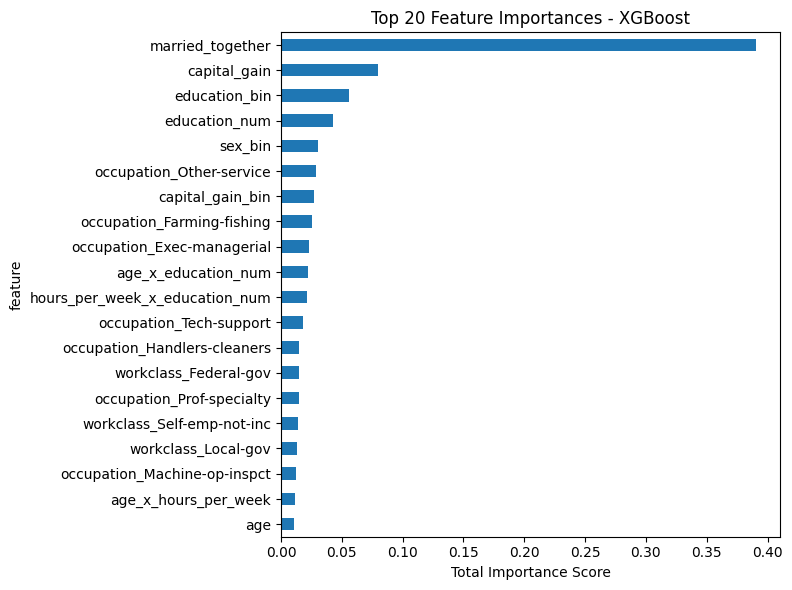

In [35]:
# Plot feature importances
Path("../images").mkdir(parents=True, exist_ok=True)

# build plot
ax = fi_df.sort_values("importance", ascending=False).head(20).plot(
    x="feature", y="importance", kind="barh", figsize=(8, 6), legend=False
)
ax.set_title("Top 20 Feature Importances - XGBoost")
ax.invert_yaxis()
ax.set_xlabel("Total Importance Score")
ax.figure.tight_layout()

# save first, then show
ax.figure.savefig("../images/xgb_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()


### Grouped feature importance

In [ ]:
# Map encoded feature names to their original feature group
group_map = {}
for name in feature_names:
    # Example names from OneHotEncoder: "workclass_Private", "race_White"
    if "_" in name:
        base = name.split("_", 1)[0]
        group_map[name] = base
    else:
        # If no underscore, use the full name (numeric or ordinal features)
        group_map[name] = name

Aggregate importances by group

In [ ]:
# Create a DataFrame with group names
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances,
    'group': [group_map[f] for f in feature_names]
})

# Group by original feature group
grouped_fi = (
    fi_df.groupby('group', as_index=False)
         .importance.sum()
         .sort_values('importance', ascending=False)
)

Plot grouped features

<Figure size 800x600 with 0 Axes>

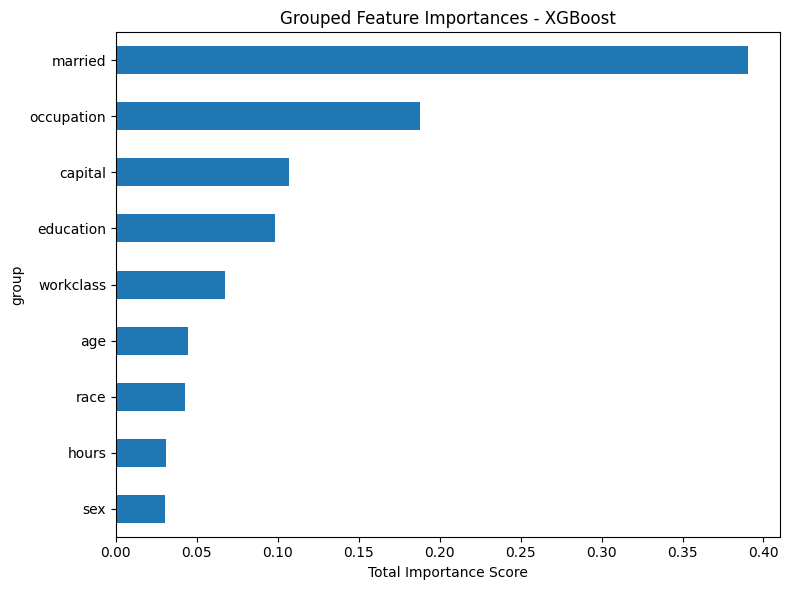

In [21]:
plt.figure(figsize=(8, 6))
grouped_fi.plot(
    x='group',
    y='importance',
    kind='barh',
    figsize=(8, 6),
    legend=False
)
plt.title('Grouped Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.xlabel('Total Importance Score')
plt.tight_layout()
plt.show()

### Evaluate bias

              precision    recall  f1-score   support

        ≤50K       0.88      0.92      0.90      4531
        >50K       0.74      0.63      0.68      1502

    accuracy                           0.85      6033
   macro avg       0.81      0.78      0.79      6033
weighted avg       0.85      0.85      0.85      6033



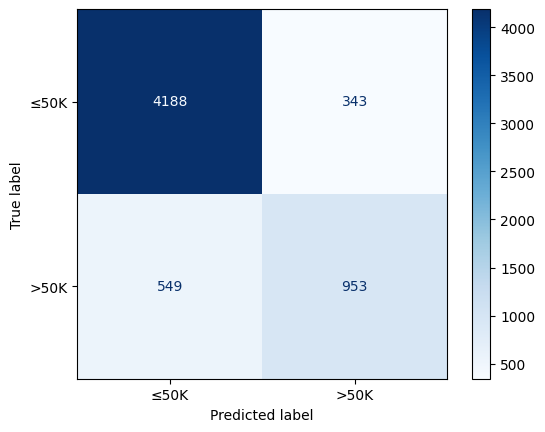

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions
xgb_model = fitted["XGBoost"]
y_pred = xgb_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=["≤50K", ">50K"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["≤50K", ">50K"])
disp.plot(cmap="Blues", values_format="d")

Calculate scale_pos_weight for retraining

In [38]:
# XGBoost’s imbalance-handling parameter
# scale_pos_weight = (# negative class samples) / (# positive class samples)
neg = np.sum(y_train == 0)  # ≤50K
pos = np.sum(y_train == 1)  # >50K
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 3.02


In [40]:
# Retrain with balanced class weights
xgb_balanced = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",
    n_jobs=-1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_balanced.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


              precision    recall  f1-score   support

        ≤50K       0.94      0.82      0.87      4531
        >50K       0.60      0.83      0.70      1502

    accuracy                           0.82      6033
   macro avg       0.77      0.82      0.78      6033
weighted avg       0.85      0.82      0.83      6033



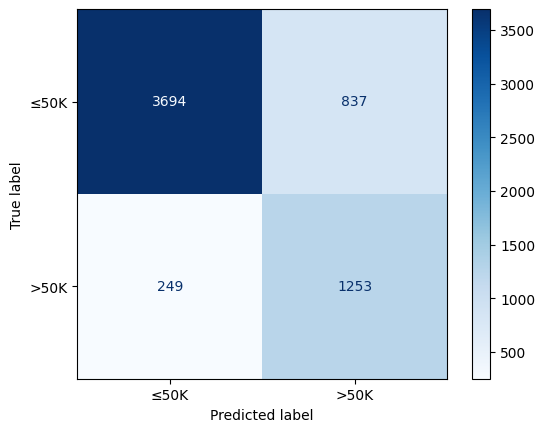

In [41]:
# Rerun evaluation
xgb_model = xgb_balanced
y_pred = xgb_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=["≤50K", ">50K"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["≤50K", ">50K"])
disp.plot(cmap="Blues", values_format="d")